In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import scipy as scp
from scipy import fftpack

The Dirichlet Energy of $e^{2 \pi i k \theta/N}$ in a length $N$ array is given by

$$
\frac 1 N \sum_{j=0}^{N-1} \left|e^{2\pi i k (j+1) /N}-e^{2\pi i k j/N}\right|^2 =  
 \left|e^{i \pi k /N }-e^{-i \pi k /N }\right|^2 = 4 sin^2(\pi k /N)
$$

We can use it to produce a GFF in the fourier space and then transform back:

In [3]:
def TorusGFF(s=1000):
    x = np.linspace(0,1-1./s, s) #get s uniformly spaced numbers, they are the k/n
    energy = 4*np.sin(np.pi*x)**2
    energy = energy[None,:]+energy[:,None] #make it 2d by saying E(k1,k2) = E(k1)+E(k2)
    energy[0,0]=1E10 # We have to kill the constant case
    amplitude = 1./(energy)**.5 #the variance of the gaussian is the inverse of the energy
    modes =   np.random.normal(size=(s,s))*amplitude +  \
           1j*np.random.normal(size=(s,s))*amplitude #Randomize the real and complex modes
    return np.real(fftpack.fft2(modes)/s) #the division by s is due to the normalisation in fft2


I'm doing a bit of darkish stuff here:
 By producing a complex gff (easier to deal with in the fft), I am exciting twice as many modes
 (the real ones and the imaginary ones). Since then I keep only the real part, I kill half of the
 modes again, so the energy produced is the right one (see the normalisation test below)
 
**Normalization test:** _(to check we are not off by a factor of 2 or something)_

We have 500^2 modes, and the dirichlet energy of each mode should be 1 in expected value, 
so the total energy should be around 500^2 (we are off by a difference of 1/500=0.002 due to not adding the energy in the 'wrapping' of the torus)

In [8]:
result = []
for i in range(50):
    gff = TorusGFF(500)
    energy = (np.sum(np.diff(gff,axis=1)**2)+np.sum(np.diff(gff,axis=0)**2))
    result.append(energy)
print(np.mean(result)/500**2) #Should give something near 1. It does

0.9983427641395447


**Let's plot a GFF **

In [9]:
gff = TorusGFF(400)

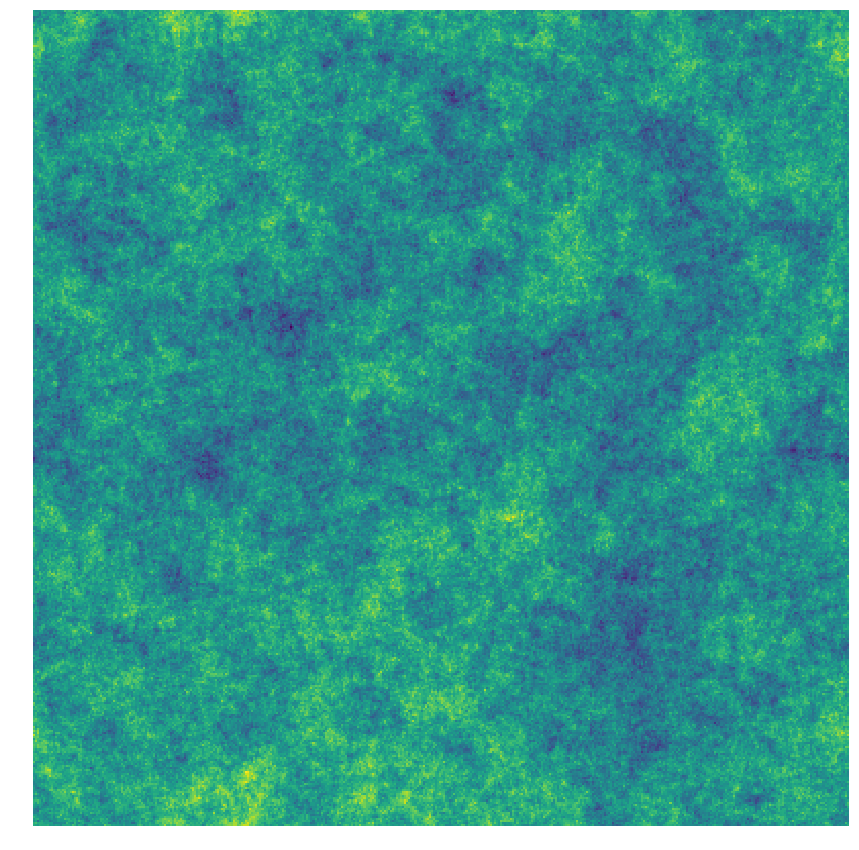

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(gff)
plt.axis('off')
plt.savefig('gff_colormap.png',dpi=200, bbox_inches='tight')

** Test on the variance of the GFF at a given point ** 

Here we test how does the variance of a single point increase as the number of samples go to infinity remember that at a given point we have O(k) modes at frequency k, and modes at frequency k have variance 1/k^2. Therefore the variance of a point at step n should be O(log n). This is consistent with the results in the continuous setting


Text(0,0.5,'Computed variance of the GFF')

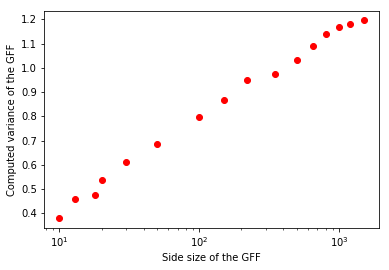

In [7]:
tests = [10,13,18,20,30,50,100,150,220,350,500,650,800,1000,1200,1500]
variance = []
n_iters = 15
for i in tests:
    var_mean = 0
    for j in range(n_iters):
        gff = np.real(TorusGFF(i))
        var = np.mean(gff.flatten()**2)
        var_mean+=var/n_iters
    variance.append(var_mean)
plt.semilogx(tests,variance,'ro')
plt.xlabel('Side size of the GFF')
plt.ylabel('Computed variance of the GFF')

** Finding the LQG balls. **

We will follow the 'probability vs size' tradeoff heuristic (described in the end of section 2 of the QLE paper, for example), which consists on making the probability of expanding the Eden model at a given node of the grid inversely proportional to the sizd (LQG measure) that point has.

We will then compute the eden balls using FPP percolation. The following is a terribly inefficient iterative algorithm to find the distances to the origin: (but hey, it's like 20 lines and works)

In [25]:
# This is a terrible heuristic iterative solver to find the distances on a grid.
# it is a terrible idea, but it was fast to implement and sort of works
def iterative_grid_solver(grid,max_iters = 400,dist = None,verbose = True): #should implement Dikjstra's instead?
    s = grid.shape[0] #size
    if dist is None:
        dist = 1E10+np.zeros_like(grid)
        dist[s//2,s//2] = 0
    for i in range(max_iters):
        if verbose and i%25 == 1: #give a result once every 25 iterations, skip the uninformative first one
            print(np.mean(dist))
        for l in range(s):
            for d in [-1,1]:
                p = s//2+l*d;
                dist[:,p%s] = np.amin([dist[:,(p-1)%s]+grid[:,p%s],
                                       dist[:,(p+1)%s]+grid[:,p%s],
                                       dist[:, p%s]],axis = 0)
                dist[p%s,:] = np.amin([dist[(p-1)%s,:]+grid[p%s,:],
                                       dist[(p+1)%s,:]+grid[p%s,:],
                                       dist[ p%s,:]],axis = 0)
    return dist

After what we have set up above, solving the Eden in a LQG is now immediate:

1: 1: Define a GFF and the associated LQG

In [18]:
gff = np.real(TorusGFF(4000))
gamma = (8/3)**.5
LQG = np.exp(gamma*gff)
LQG/= np.mean(LQG)

2: Build an exponential clock out of it to make FPP (the parameters of the exponential variables are proportional to LQG as explained above)

In [19]:
Exp_LQG = np.random.exponential(scale=LQG) 

3: Run the iterative algorithm to find the distances

In [20]:
distance = iterative_grid_solver(Exp_LQG);

9999999375.0
231.98785780787617
170.10336919585478
144.0807308787495
127.7537010900127
116.18960304928228
107.60372863923213
101.0111290469252
95.7567067153623
91.42420859851637
87.77762486713266
84.66455191182249
81.97482790700924
79.63062006237281
77.5719566494245
75.74852800155811
74.12226218607857
72.66361876536773
71.34728742288742
70.15382459797249
69.06683492344662
68.07354676381291
67.16538038412544
66.33384655191767
65.57072874599183
64.86788758713654
64.2190214510517
63.61886323944518
63.06264401454714
62.54661345760636
62.06754090831981
61.62246570453502
61.208479388432245
60.822762783658824
60.46293361982115
60.12701482007285
59.8132440744967
59.51985012517034
59.245220180716046
58.98792247111405


4: Make a nice plot out of it

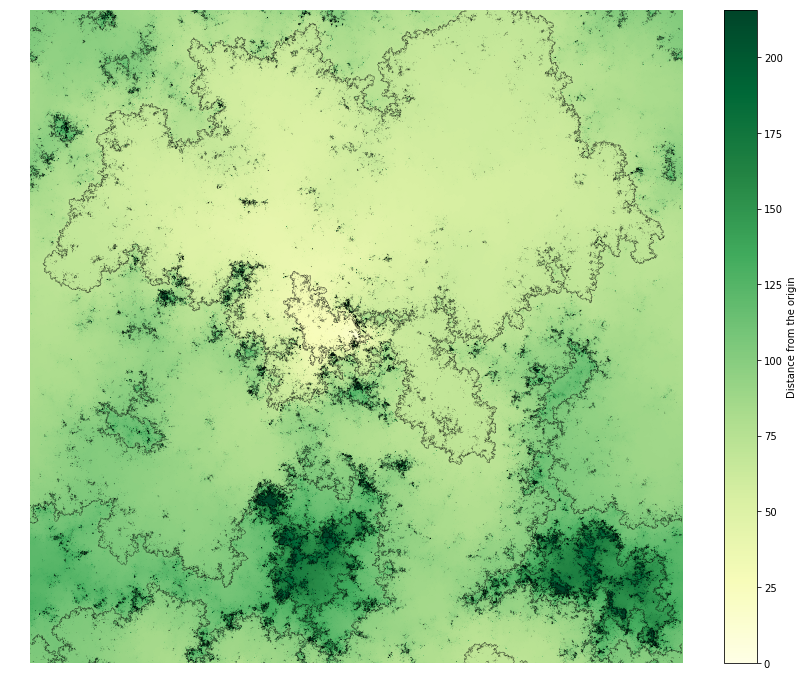

In [13]:
plt.figure(figsize=(15,12))
vmax = np.percentile(distance,99.8)
plt.imshow(distance,cmap='YlGn',vmax=vmax,extent = [0,1,1,0]) 
plt.colorbar(label='Distance from the origin')

x = np.linspace(0,1,distance.shape[0])
X,Y = np.meshgrid(x,x)
levels = np.linspace(0,vmax,6+1)
plt.contour(X, Y, distance,levels = levels,colors = 'k',linewidths=.2)

plt.axis('off')

plt.savefig('Eden_balls_distance.png',dpi=300, bbox_inches='tight')

We can now make a nice video out of it by sweeping on gamma (the images have to be merged later manually). We prepare a couple of helper functions (a plotter and a function to normalise the metric with respect of gamma)

In [10]:
def mean_weighted_distance(gff,distances,gamma):
    return np.sum(np.exp(gamma*gff)*distances)/np.sum(np.exp(gamma*gff))

In [11]:

def plot_image(i):
    dist = result[i]
    s = dist.shape[0]
    
    plt.figure(figsize=(7.5,6)) 
    plt.imshow(dist,cmap='YlGn',vmax=2,extent = [0,1,1,0]) 
    plt.colorbar(label='Distance from the origin')

    x = np.linspace(0,1,s)
    X,Y = np.meshgrid(x,x)
    levels = np.linspace(0,1,5+1)
    plt.contour(X, Y, dist,levels = levels,colors = 'k',linewidths=.2)

    plt.axis('off')

    plt.title('$\\gamma$ = {0:.2f}\n'.format(gammas[i]))
    plt.savefig('Animation/{}.png'.format(i),dpi=150)
    plt.close() #close the matplotlib figure

In [ ]:
%matplotlib auto

gammas = np.linspace(0,(8/3)**.5,50) #list of gammas
result = [] #to store the distance matrices
s = 600 # size

gff = TorusGFF(s) #sample a single gff for all the pictures
exp_noise = np.random.exponential(size=(s,s)) #sample a single exponential clock (to be scaled) for all the pictures

for i,g in enumerate(gammas):
    print(i, end=" ")
    
    LQG = np.exp(g*gff) #exponentiate the field
    LQG/= np.mean(LQG) #normalize LQG
    Exp_LQG = exp_noise*LQG #create the random exponential clocks (coordinated for all the pictures)
    
    dist = iterative_grid_solver(Exp_LQG,max_iters = 350,verbose = False) #compute the distance matrix to the origin
    dist = dist/mean_weighted_distance(gff,dist,g) #normalize so that the mean distance is 1
    
    result.append(dist)
    plot_image(i) #plot the image
    
%matplotlib inline

**Trying to reduce the noise:**

We will sample more than one 'FPP' configuration for the same LQG, and average the distance functions. This will give a hopefully more acurate version of the balls

In [22]:
gff = np.real(TorusGFF(2000))
gamma = (8/3)**.5
LQG = np.exp(gamma*gff)
LQG/= np.mean(LQG)

In [24]:
distances = [iterative_grid_solver(np.random.exponential(scale=LQG))
               for i in range(5)];

9999997500.0
53.37950285922886
40.21813864147764
34.684875244932314
31.58388460641517
29.643567844599513
28.369176735254896
27.478386879950765
26.827574721307414
26.343013195789496
25.97899067706571
25.701523609792968
25.488578930796823
25.32519373070395
25.199169633007166
25.09932996367507
9999997500.0
53.13549969032837
39.67269119990681
34.074890429072006
30.949605705000653
28.98846317195684
27.676852955833976
26.769913521062357
26.121792496473994
25.643581843176825
25.2829691038653
25.010450147139487
24.802643151840325
24.64317715053284
24.520511381223226
24.424929360609895
9999997500.0
54.027319476388854
40.10437357261889
34.45188470603204
31.347233387409435
29.424348953540296
28.153140591692864
27.275569015395075
26.64649983278122
26.181841814862867
25.830830517303166
25.563324245036306
25.357747455595714
25.199434914278182
25.076342342888562
24.97971951923019
9999997500.0
54.19275599018433
40.5245903790605
34.93782771310695
31.838550553098415
29.87809449419079
28.551883190030264


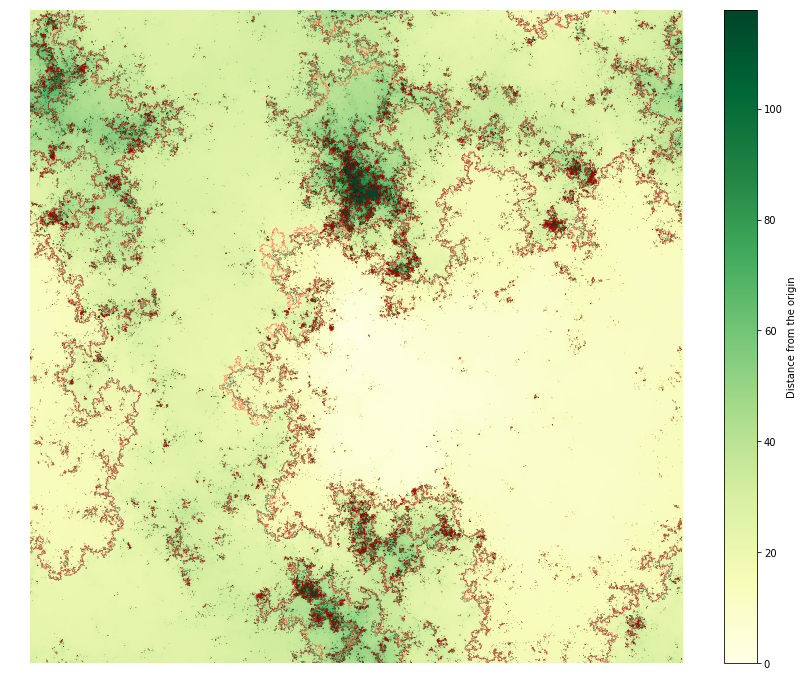

In [35]:

median = np.median(distances,axis=0)
plt.figure(figsize=(15,12))
vmax = np.percentile(distance,99.8)
plt.imshow(distance,cmap='YlGn',vmax=vmax,extent = [0,1,1,0]) 
plt.colorbar(label='Distance from the origin')

x = np.linspace(0,1,distance.shape[0])
X,Y = np.meshgrid(x,x)
levels = np.linspace(0,vmax,6+1)
plt.contour(X, Y, distances[0],levels = levels,colors = 'k',linewidths=.2)
plt.contour(X, Y, median      ,levels = levels,colors = 'r',linewidths=.2)


plt.axis('off')

plt.savefig('Eden_balls_distance_averaged.png',dpi=300, bbox_inches='tight')

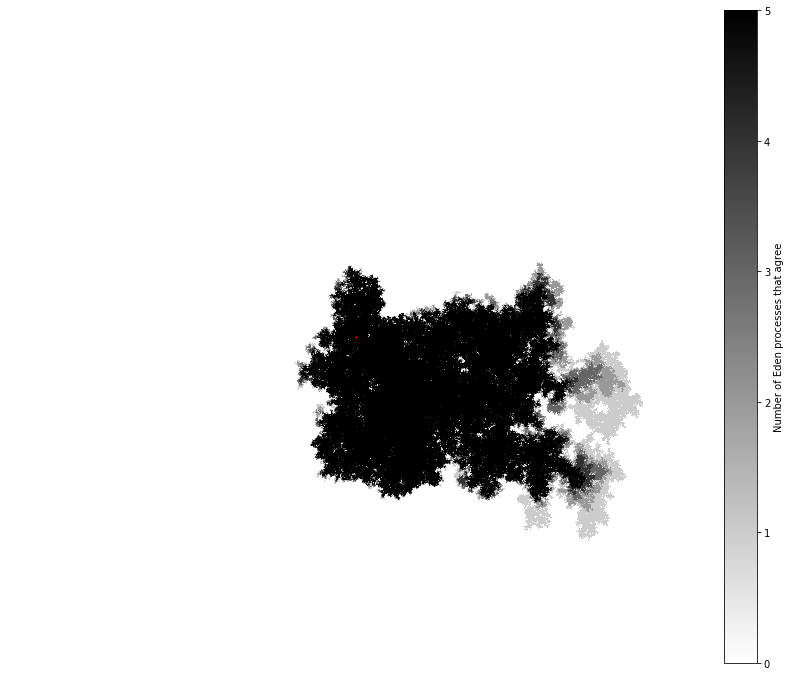

In [49]:
median = np.mean(np.array(distances)<10,axis=0)*len(distances)
plt.figure(figsize=(15,12))
plt.imshow(median,cmap='binary',extent = [0,1,1,0]) 
plt.colorbar(label='Number of Eden processes that agree')
plt.plot([.5],[.5],'r.',ms=2)
plt.axis('off')

plt.savefig('Eden_balls_distance_threshold.png',dpi=300, bbox_inches='tight')

In [11]:
def LQG_instance(gamma = (8/3)**.5, N=1000):
    gff = TorusGFF(N)
    LQG = np.exp(gamma*gff)
    LQG/= np.mean(LQG)
    return LQG

In [143]:
def argmin(s): #argmin of a dictionary, helper function
    return min(s.iteritems(), key=lambda x: x[1])[0]

def min_dist(weights,center=False):
    
    sx,sy = weights.shape
    if center:
        cx,cy = center
    if not center:
        cx=sx//2;
        cy=sy//2

    distance = np.zeros_like(weights)+1E10;
    distance[center]=0;
    done = np.zeros(shape = weights.shape, dtype = bool)
    active = {(cx,cy):0}
    print active.keys()
    i = 0
    while len(active)>0:
        if i%10000 == 0:
            print i/(sx*sy*1.0)*100,
        m = argmin(active)
        mx,my = m
        
        distance[m] = active[m]
        done[m] = True
        active.pop(m,None)
        
        for dx,dy in ((-1,0),(1,0),(0,1),(0,-1)):
            neigh = ((mx+dx)%sx,(my+dy)%sy)
            if not done[neigh]:
                if not neigh in active:
                    active[neigh] = weights[neigh]+distance[m]
                else:
                    active[neigh] = min(active[neigh],
                                            weights[neigh]+distance[m])
        i+=1
    return distance

In [160]:
x = np.linspace(-.5,.5, 250)
x,y = np.meshgrid(x,x)
logd = .5*np.log(x**2+y**2+1.1/250)

In [184]:
LQG = np.random.exponential(LQG_instance(gamma = 2**.5,N=250)-2**.5*logd)

In [185]:
distance = min_dist(LQG)

[(125, 125)]
0.0 16.0 32.0 48.0 64.0 80.0 96.0


(0.0, 1.0, 1.0, 0.0)

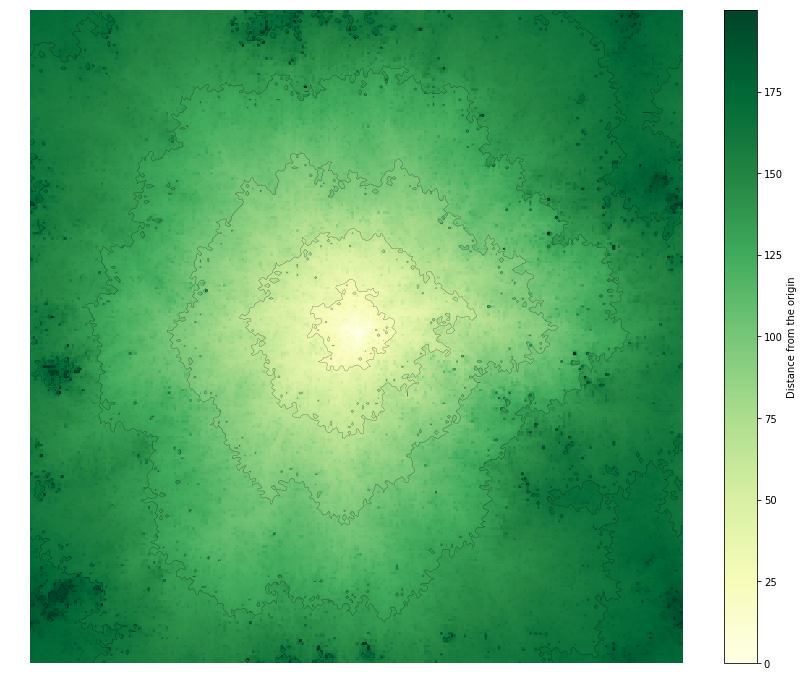

In [186]:

plt.figure(figsize=(15,12))
vmax = np.percentile(distance,99.8)
plt.imshow(distance,cmap='YlGn',vmax=vmax,extent = [0,1,1,0]) 
plt.colorbar(label='Distance from the origin')

x = np.linspace(0,1,distance.shape[0])
X,Y = np.meshgrid(x,x)
levels = np.linspace(0,vmax,6+1)
plt.contour(X, Y, distance ,levels = levels,colors = 'k',linewidths=.2)


plt.axis('off')



In [37]:
n_reps = 30
sizes = np.logspace(1,3,20).astype(int)
norms = [np.mean([np.mean(np.abs(TorusGFF(size))) for i in range(n_reps)]) for size in sizes]

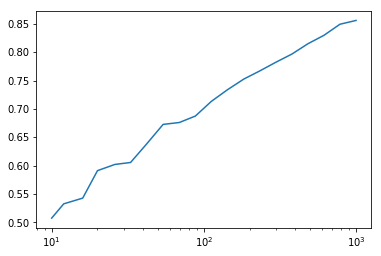

In [38]:
plt.semilogx(sizes,norms)